# KnowLow = No Low
## DirecNetExercise2Study - Effect of exercise per se on the risk of nocturnal hypoglycemia
### Attempts to evaluate the most effective methods of adjusting insulin doses during exercise in order to maximize the benefits and safety of exercise in children with T1DM by preventing hypoglycemia during and following exercise.

In [597]:
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, roc_curve, precision_recall_curve, auc  
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import datetime
from random import randint
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/home/rashi/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [598]:
df_cgms = pd.read_csv('data/DataTables/tblGDataCGMS.csv', sep=',', header=None)
df_cgms.columns = df_cgms.iloc[0]
# Use first row info as header
df_cgms.drop(df_cgms.index[0], inplace=True)
# Drop first row

#df_cgms['ReadingTm'] = pd.to_datetime(df_cgms['ReadingTm']).dt.strftime('%H:%M')
# To get rid of some PM inputs
df_cgms['ReadingTm'] = pd.to_datetime(df_cgms['ReadingTm']).dt.round('5min').dt.strftime('%H:%M')
# rounding time to every 5 min for convenience!
df_cgms['ReadingDt'] = pd.to_datetime(df_cgms['ReadingDt']).dt.date

df_cgms['SensorGLU'] = pd.to_numeric(df_cgms['SensorGLU'])
df_cgms['MeterBG'] = pd.to_numeric(df_cgms['MeterBG'])
df_cgms['Diff'] = df_cgms['SensorGLU'] - df_cgms['MeterBG']
df_cgms['Diff'] = df_cgms['Diff'].abs()

df_cgms = df_cgms.drop('RecID', axis=1)
# drop unnecessary columns

#df_cgms.set_index('ReadingTm', inplace=True)
df_cgms.tail()
#gpd_cgms = df_cgms.groupby(['PtID', 'ReadingDt'])
#gpd_cgms.head()

,PtID,GVisitType,ReadingDt,ReadingTm,MeterBG,SensorGLU,Diff
14955,52,Basal stopped,2000-01-18,18:15,NaN,117,NaN
14956,52,Basal stopped,2000-01-18,18:20,NaN,117,NaN
14957,52,Basal stopped,2000-01-18,18:25,NaN,119,NaN
14958,52,Basal stopped,2000-01-18,18:30,NaN,125,NaN
14959,52,Basal stopped,2000-01-18,18:35,NaN,134,NaN


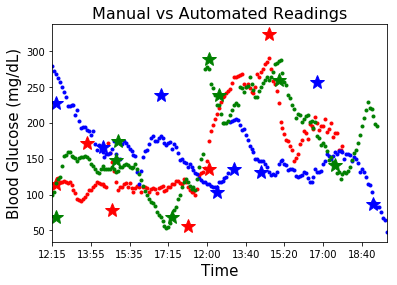

In [640]:
df_basal = df_cgms#[df_cgms['GVisitType'] == "Basal continued"]

df1 = df_basal[df_basal['PtID'] == '35']
df2 = df_basal[df_basal['PtID'] == '3']
df3 = df_basal[df_basal['PtID'] == '10']
#df_4 = df_4[df_4['GVisitType'] == 'Basal continued']

ax = df1.plot(x="ReadingTm",y="SensorGLU",style='r.')
df1.plot(x="ReadingTm",y="MeterBG",style='r*',markersize=15,ax=ax)

df2.plot(x="ReadingTm",y="SensorGLU",style='b.',ax=ax)
df2.plot(x="ReadingTm",y="MeterBG",style='b*',markersize=15,ax=ax)

df3.plot(x="ReadingTm",y="SensorGLU",style='g.',ax=ax)
df3.plot(x="ReadingTm",y="MeterBG",style='g*',markersize=15,ax=ax)

ax.set_title("Manual vs Automated Readings", fontsize=16)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Blood Glucose (mg/dL)", fontsize=15)
ax.legend_.remove()
plt.savefig('ManVsAuto.png')

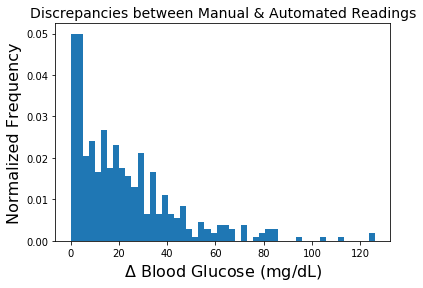

In [639]:
ax = df_cgms["Diff"].plot.hist(bins=50, normed=True)
ax.set_title("Discrepancies between Manual & Automated Readings", fontsize=14)
ax.set_ylabel("Normalized Frequency", fontsize=16)
ax.set_xlabel(r"$\Delta$ Blood Glucose (mg/dL)", fontsize=16)
plt.savefig('hist_discrepancies.png')

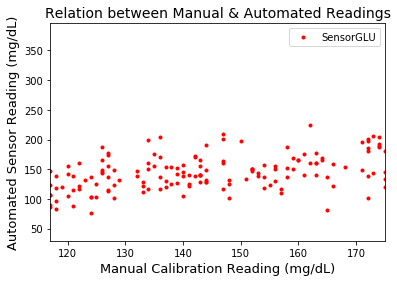

In [649]:
df_dropna = df_cgms.dropna(subset = ['MeterBG'])
df_dropna.plot(x="MeterBG",y="SensorGLU",style='r.')
title("Relation between Manual & Automated Readings", fontsize=14)
ylabel("Automated Sensor Reading (mg/dL)", fontsize=13)
xlabel("Manual Calibration Reading (mg/dL)", fontsize=13)
plt.savefig('auto_vs_manual.png')

In [601]:
df_free = pd.read_csv('data/DataTables/tblGDataFreestyle.csv', sep=',', header=None)
df_free.columns = df_free.iloc[0]
# Use first row info as header
df_free.drop(df_free.index[0], inplace=True)
# Drop first row

df_free['ReadingDtTm'] = pd.to_datetime(df_free['ReadingDtTm']).dt.round('5min')
# rounding time to every 5 min, corresponding with CGMS data
df_free['ReadingDt'] = df_free['ReadingDtTm'].dt.date
df_free['ReadingTm'] = df_free['ReadingDtTm'].dt.strftime('%H:%M')
# separating out dates and types into
 
df_free['PtID'] = pd.to_numeric(df_free['PtID'])
df_free['ReadingValue'] = pd.to_numeric(df_free['ReadingValue'])

df_free = df_free.drop(['RecID','ReadingDtTm','BGType','ReadingType'], axis=1)
# drop unnecessary columns

df_free = df_free.dropna()
# drop rows with any column having NA/null data

#df_free = df_free[df_free['GVisitType'] == "Basal stopped"]
# NOTE: ONLY USE BASAL STOPPED ONES FOR NOW

#df_free = df_free[df_free['GFreeSampleType'] == "ExEnd"]

#df_free = df_free.groupby(['PtID', 'ReadingDtTm', 'GFreeSampleType'])
df_free.head()

,PtID,GVisitType,GFreeSampleType,ReadingValue,ReadingDt,ReadingTm
1,14,Basal continued,Additional,73,2000-01-01,11:15
2,14,Basal continued,Additional,75,2000-01-01,11:30
3,14,Basal continued,Additional,75,2000-01-01,12:20
4,14,Basal continued,1PM,68,2000-01-01,13:00
5,14,Basal continued,2PM,48,2000-01-01,14:00


In [602]:
df_snack = pd.read_csv('data/DataTables/tblGSnackData.csv', sep=',', header=None)
df_snack.columns = df_snack.iloc[0]
# Use first row info as header
df_snack.drop(df_snack.index[0], inplace=True)
# Drop first row

df_snack = df_snack.replace({'True':1,'False':0})

df_snack['CarbDtTm'] = pd.to_datetime(df_snack['CarbDtTm']).dt.round('5min')
# rounding time to every 5 min, corresponding with CGMS data
df_snack['ReadingDt'] = df_snack['CarbDtTm'].dt.date
df_snack['ReadingTm'] = df_snack['CarbDtTm'].dt.strftime('%H:%M')
# separating out dates and types into separate columns

df_snack['PtID'] = pd.to_numeric(df_snack['PtID'])
df_snack['GmCarbs'] = pd.to_numeric(df_snack['GmCarbs'])

df_snack = df_snack.drop(['RecID','CarbDtTm','GSnackSource'], axis=1)
# drop unnecessary columns
df_snack.head()

,PtID,BedtimeSnack,GmCarbs,TxHypo,Dinner,ReadingDt,ReadingTm
1,3,0,57.0,0,1,2000-04-02,18:05
2,3,0,57.0,0,1,2000-04-18,18:10
3,3,0,15.0,0,0,2000-04-02,17:50
4,3,1,NaN,0,0,2000-04-02,21:20
5,3,0,12.0,1,0,2000-04-03,00:10


In [603]:
# Printing out unique patients in each dataset

patients_cgms = np.sort(np.unique(df_cgms['PtID'].astype(int)))
print(patients_cgms, len(patients_cgms))

patient = patients_cgms[randint(0, len(patients_cgms))]
print(patient)

patients_free = np.sort(np.unique(df_free['PtID'].astype(int)))
print(patients_free, len(patients_free))

patients_snack = np.sort(np.unique(df_snack['PtID'].astype(int)))
print(patients_snack, len(patients_snack))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52
 53 54 55 56 57] 55
39
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52
 53 54 55 56 57] 55
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52 53 54
 55 56 57] 53


In [604]:
# COMBINING CGMS, EXERCISE AND SNACK DATASETS, PATIENT-WISE:
# PIP PIP! GET ON WITH IT!
bg = []; status = []; hypo = []
for i in range(df_cgms.shape[0]):
# looping through rows of df_cgms
    patient = pd.to_numeric(df_cgms['PtID'].iloc[i])
    date = df_cgms['ReadingDt'].iloc[i]
    time = df_cgms['ReadingTm'].iloc[i]
# make sure type(patient), type(date) and type(time) match with df_free column types!
 
    mask_free = (df_free['PtID'] == patient) & (df_free['ReadingDt']==date) & (df_free['ReadingTm']==time)
    matches = df_free['ReadingValue'].loc[mask_free].values#[0]
    if(len(matches) != 0):
      ex_bg = matches[0]
      ex_status = 1
    else:
      ex_bg = df_cgms['SensorGLU'].iloc[i]
      ex_status = 0
    bg.append(ex_bg)
    status.append(ex_status)
    
    mask_snack = (df_snack['PtID'] == patient) & (df_snack['ReadingDt']==date) & (df_snack['ReadingTm']==time)
    matches = df_snack['TxHypo'].loc[mask_snack].values
    if(len(matches) != 0):
      hypo_status = matches[0]
    else:
      hypo_status = 0
    hypo.append(hypo_status)
df_cgms['ExBG'] = bg
df_cgms['ExStat'] = status
df_cgms['Episode'] = hypo
print(len(df_cgms[df_cgms['Episode'] == 1]))

df_cgms.to_csv('data/DataTables/modified_cgms.csv', sep=',')
# Save modified dataframe to csv file
df_cgms.head()

86


,PtID,GVisitType,ReadingDt,ReadingTm,MeterBG,SensorGLU,Diff,ExBG,ExStat,Episode
1,26,Basal stopped,2000-02-26,11:55,NaN,146,NaN,146,0,0
2,26,Basal stopped,2000-02-26,12:00,NaN,144,NaN,117,1,0
3,26,Basal stopped,2000-02-26,12:05,117.0,147,30.0,147,0,0
4,26,Basal stopped,2000-02-26,12:10,NaN,145,NaN,145,0,0
5,26,Basal stopped,2000-02-26,12:15,NaN,144,NaN,144,0,0


In [605]:
# Checking if pandas can read saved csv properly
df_saved = pd.read_csv('data/DataTables/modified_cgms.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_saved.columns = df_saved.iloc[0]
# Use first row info as header
df_saved.drop(df_saved.index[0], inplace=True)
# Drop first row
df_saved.head()
#print("hi", df_saved.columns)

,nan,PtID,GVisitType,ReadingDt,ReadingTm,MeterBG,SensorGLU,Diff,ExBG,ExStat,Episode
1,1.0,26,Basal stopped,2000-02-26,11:55,NaN,146,NaN,146,0,0
2,2.0,26,Basal stopped,2000-02-26,12:00,NaN,144,NaN,117,1,0
3,3.0,26,Basal stopped,2000-02-26,12:05,117.0,147,30.0,147,0,0
4,4.0,26,Basal stopped,2000-02-26,12:10,NaN,145,NaN,145,0,0
5,5.0,26,Basal stopped,2000-02-26,12:15,NaN,144,NaN,144,0,0


In [606]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
############################ End of series_to_supervised function ####################################

x2= []; i = 52; 
patient_i = df_cgms[df_cgms['PtID'] == str(i)]
##### including 2nd feature #####
raw['ob1'] = list(patient_i['ExBG'])
raw['ob2'] = list(patient_i['ExStat'])
values2 = raw.values
data = series_to_supervised(values2, len(patient_i)-2, 2)

In [607]:
#################################### Creating input x & y arrays ###################################
max_rows = max(df_cgms['PtID'].value_counts())
x = []; x2 = []
for i in patients_cgms:
  patient_i = df_cgms[df_cgms['PtID'] == str(i)]
  values = list(patient_i['ExBG'])
  data = series_to_supervised(values, len(patient_i)-1)
  modified = data.values[0]
    
  if(len(modified) < max_rows):
    col_diff = max_rows - len(modified)
    for j in range(col_diff):
      modified = np.append(modified,0)
# input zeros for missing columns, to make all patients have same number of rows

  x.append(modified)
   
#  x.append(data.as_matrix())
'''
##### including 2nd feature #####
  raw['ob1'] = list(patient_i['ExBG'])
  raw['ob2'] = list(patient_i['ExStat'])
  values2 = raw.values
  data = series_to_supervised(values2, len(patient_i)-2, 2)
  x2.append(data)
print(len(x), len(x2))    
'''

"\n##### including 2nd feature #####\n  raw['ob1'] = list(patient_i['ExBG'])\n  raw['ob2'] = list(patient_i['ExStat'])\n  values2 = raw.values\n  data = series_to_supervised(values2, len(patient_i)-2, 2)\n  x2.append(data)\nprint(len(x), len(x2))    \n"

In [608]:
x = np.array(x)
np.shape(x)
#print(len(x[0][0]), len(x[1][0]), len(x[2][0]))
    

(55, 1592)

In [609]:
# Regression Outcome as Mean number of hypoglycemic episodes
df_snack_mean = df_snack.groupby('PtID').mean()
hypo_out = df_snack_mean['TxHypo']
hypo_out.head()

PtID
3    0.125000
4    0.333333
5    0.000000
6    0.250000
7    0.000000
Name: TxHypo, dtype: float64

In [610]:
df_cgms_mean = df_cgms.groupby('PtID').mean()
mean = df_cgms_mean['Episode']
y = mean
y.iloc[y.nonzero()[0]] = 1
# replacing non-zero values with 1
y = y.as_matrix()
print(y)

[ 1.  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.
  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.
  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.
  1.]


In [662]:
from sklearn.model_selection import train_test_split

######################### Building Training and Testing Datasets ##############################
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)
#x_train = np.array(x_train); x_test = np.array(x_test);
#y_train = np.array(y_train); y_test = np.array(y_test);

print(len(x_train), len(x_test),len(y_train), len(y_test))

41 14 41 14


In [663]:
######################################### Training Forest ####################################################
def train_rf(x_train, y_train, trees_rf, samples_rf):
  model = RandomForestClassifier(min_samples_leaf=samples_rf, oob_score=True, n_estimators=trees_rf) #, warm_start=True, min_samples_split=1)
  model.fit(x_train,y_train)
  return model

model = train_rf(x_train, y_train, 100, 5)
joblib.dump(model,'model.pkl') 

['model.pkl']

In [664]:
########################################### Testing ####################################################
def testing(x_test, model):
  y_pred = model.predict(x_test)
  prob = model.predict_proba(x_test) # To get confidence of the prediction
  return np.array(y_pred), np.array(prob)

y_pred, prob = testing(x_test, model)

In [665]:
####################################### Visualize model Predictions ###############################################
def plot_confusion_matrix(cm, ylabel, xlabel):
  plt.figure()
  cmap = plt.cm.Blues
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title('Normalized Confusion Matrix', fontsize=16)
  plt.colorbar()
  for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
# write cm values on grid
  tick_labels = ['normal', 'hypo']
  tick_marks = np.arange(len(tick_labels))
  plt.xticks(tick_marks, tick_labels, rotation=45)
  plt.yticks(tick_marks, tick_labels)
  plt.tight_layout()
  plt.ylabel(ylabel, fontsize=16)
  plt.xlabel(xlabel, fontsize=16)

def plot_hist(prob_meta, prob_prec):
  fig = plt.figure()
  ax1 = fig.add_subplot(211)
  ax2 = fig.add_subplot(212)

  results, edges = np.histogram(prob_meta, bins=np.linspace(0,1,21,endpoint=True) , normed=True)
  binWidth = edges[1] - edges[0]
  ax1.bar(edges[:-1], results*binWidth, binWidth, facecolor='b', label = 'Normal')  

  results, edges = np.histogram(prob_prec, bins=np.linspace(0,1,21,endpoint=True), normed=True)
  binWidth = edges[1] - edges[0]
  ax2.bar(edges[:-1], results*binWidth, binWidth, facecolor='r', label = 'Hypo')

  ax1.set_xlim(0,1)
  ax2.set_xlim(0,1)
  ax1.set_ylim(0,1)
  ax2.set_ylim(0,1)

  plt.suptitle('Predicted Hypoglycemic Episode Probabilities', fontsize=15)
  ax1.set_ylabel('Probability', fontsize=15)
  ax2.set_ylabel('Probability', fontsize=15)
  ax2.set_xlabel('Hypoglycemic Episode Prediction Probability', fontsize=15)
  ax1.legend(loc='best', fontsize=20)
  ax2.legend(loc='best', fontsize=20)
  #plt.tight_layout()

correct predictions (0 in 0 & 1 in 1): 50.0
mean probabilities = for 0: 0.44 & for 1: 0.56
Confusion Matrix true_pred:
 [[1 5]
 [2 6]]
oob_score 0.46


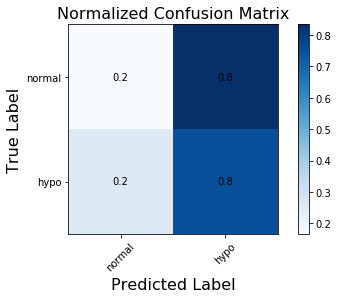

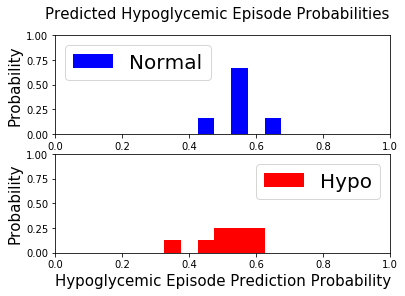

In [666]:
################################################# Prediction & Performance ################################################# 
def prediction(x_test, y_test, y_pred, prob, model):
  cm_true_pred = confusion_matrix(y_test, y_pred, labels = [0, 1])
  ncm_true_pred = cm_true_pred.astype('float') / cm_true_pred.sum(axis=1)[:, np.newaxis]
# Normalize the confusion matrix by row (i.e by the number of samples in each class)

  print("correct predictions (0 in 0 & 1 in 1):", np.round((cm_true_pred[0][0]+cm_true_pred[1][1])*100.0/np.sum(cm_true_pred), 2))
  print("mean probabilities = for 0:", np.round(np.mean(prob[:,0]), 2), '& for 1:', np.round(np.mean(prob[:,1]), 2))
  print("Confusion Matrix true_pred:\n", cm_true_pred)
  plot_confusion_matrix(ncm_true_pred, 'True Label', 'Predicted Label')
  plt.savefig('ncm.png')

  print("oob_score", np.round(model.oob_score_, 2))

# plot 1D histogram of 1ursor probabilities in '0' and '1' regions:
  prob_0 = prob[y_test == 0, 1]
  prob_1 = prob[y_test == 1, 1]
  plot_hist(prob_0, prob_1)
  plt.savefig('hypo_prob.png')

prediction(x_test, y_test, y_pred, prob, model)

In [667]:
################# TESTING CONDITIONAL INPUT TO ELEMENT OF DATAFRAME ###############
t1 = "12:15"
t2 = "13:00"
bg1 = 200
bg2 = 150
#t1 = pd.to_datetime(t1)
#t1 = t1.strftime('%H:%M')
df_new = df_cgms[df_cgms['PtID'] == '26']
#df_new['ExBG'][df_new['ReadingTm'] == t1] = bg1
#df_new['ExBG'][df_new['ReadingTm'] == t2] = bg2
df_new = df_new.append({'PtID':'26', 'ReadingTm':t1, 'ExBG':bg1}, ignore_index=True)
df_new = df_new.append({'PtID':'26','ReadingTm':t2, 'ExBG':bg2}, ignore_index=True)
# NOTE: append adds new row if t1 & t2 don't exist; otherwise replaces them! Nice feature!!

In [617]:
x_check = x_test[0].reshape(1, -1) 
y_pred, prob = testing(x_check, model)
y_pred[0]

1.0